In [1]:
import pandas as pd
import numpy as np
import ast
import json
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from math import isnan as isnan

np.random.seed(seed = 42)

In [2]:
df = pd.read_csv('data/final_dataset_reduced.csv')

In [3]:
default_social_tags = {
 "Ariana Grande" : "pop",
 "BTS (방탄소년단)": "pop",
 "Beyoncé": "rnb",
 "Billie Eilish": "indie pop",
 "Cardi B": "hip-hop",
 "Charlie Puth": "pop",
 "Coldplay": "alternative rock",
 "Drake": "hip-hop",
 "Dua Lipa": "pop",
 "Ed Sheeran": "pop",
 "Eminem": "hip-hop",
 "Justin Bieber": "pop",
 "Katy Perry": "pop",
 "Khalid": "rnb",
 "Lady Gaga": "pop",
 "Maroon5": "pop",
 "Nicki Minaj": "hip-hop",
 "Post Malone": "hip-hop",
 "Rihanna": "rnb",
 "Selena Gomez": "pop",
 "Taylor Swift": "pop"
}

In [4]:
ignore_tags = {'favorites', 'female vocalists', 'singer-songwriter', 'love', 'beautiful', 'male vocalists', 'seen live', 'favourites', 'favorite', 'female vocalist', 'favorite songs',' favourite', 'male vocalist', 'favourite songs', 'heard on pandora'}


In [5]:
dataset_dict_list = df.to_dict('records')

with open('data/good_tags.json', 'r') as fp:
    good_tags = set(json.load(fp))
    

In [6]:
# dict of tags for each song as a weighted string ie. ["pop pop pop pop", "hip-hop, hip-hop"]
weighted_list_of_str_tags = []

good_tags_list = list(good_tags)

for song_index, row in enumerate(dataset_dict_list):

    song_social_tags = ast.literal_eval(row['social_tags']) if not pd.isna(row['social_tags']) else []
    song_emotion_tags = ast.literal_eval(row['emotion_tags']) if not pd.isna(row['emotion_tags']) else []

    # add default social tag to 21 artists
    if row['artist'] in default_social_tags and len(song_social_tags) == 0:
        song_social_tags = [(default_social_tags[row['artist']], 100)]

        #add some random variation to tags
        # for i in range(0):
        #     song_social_tags.append((random.choice(good_tags_list), random.randint(10, 30)))

    weighted_tags_list = []

    for tag, value in (song_social_tags + song_emotion_tags):
        value = int(value)
        if (tag in good_tags) and (tag not in ignore_tags):
            # add the number of tags * (value // 10)
            for i in range(value // 10):
                weighted_tags_list.append(re.sub(r'\W+', '', tag))
    
    weighted_list_of_str_tags.append("` ".join(weighted_tags_list))

In [7]:
vectorizer = TfidfVectorizer()
td_matrix = vectorizer.fit_transform(weighted_list_of_str_tags)
print(td_matrix.shape)

(32028, 157)


In [8]:
feature_names = vectorizer.get_feature_names() 
print(len(feature_names))

157


In [30]:
with open('feature_names.json', 'w') as fp:
  json.dump(feature_names, fp)

In [9]:

# # do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
# u,s,v_trans = svds(td_matrix, k=143)

In [10]:
# print(u.shape)
# print(s.shape)
# print(v_trans.shape)

In [11]:
# import matplotlib
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(s[::-1])
# plt.xlabel("Singular value number")
# plt.ylabel("Singular value")
# plt.show()

In [12]:
# these should be the three output matrices -> not sure if rest of code is important (normalization)
u, s, v_trans = svds(td_matrix, k=15)
v = v_trans.transpose()

In [32]:
with open('v_matrix.json', 'w') as fp:
  json.dump(v.tolist(), fp)

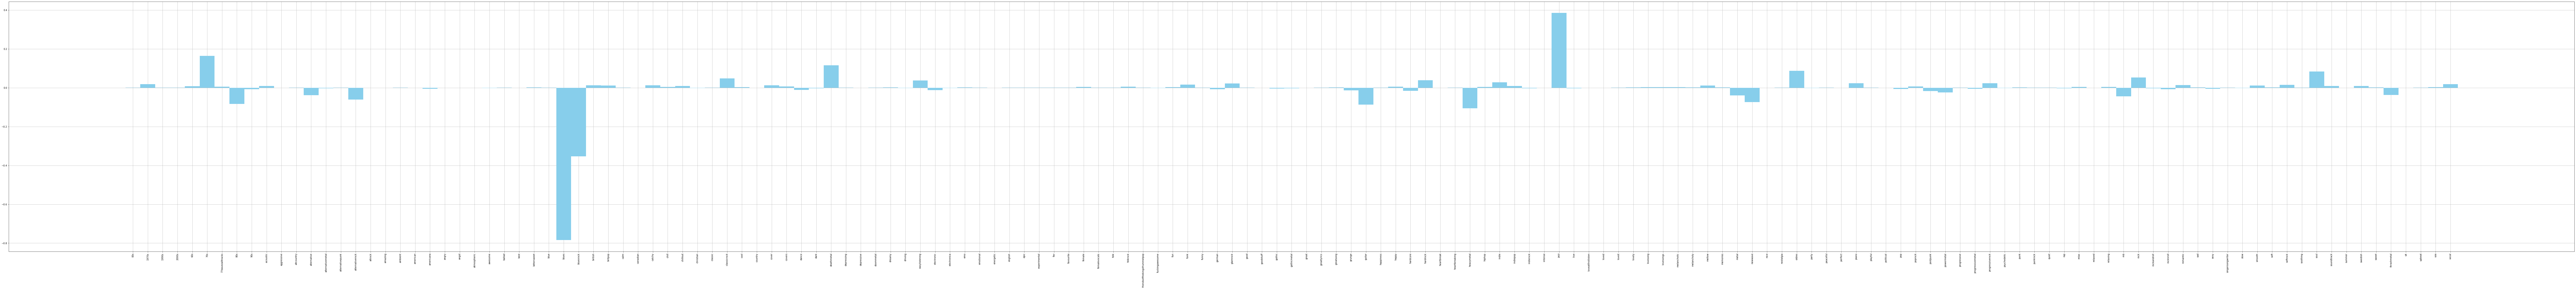

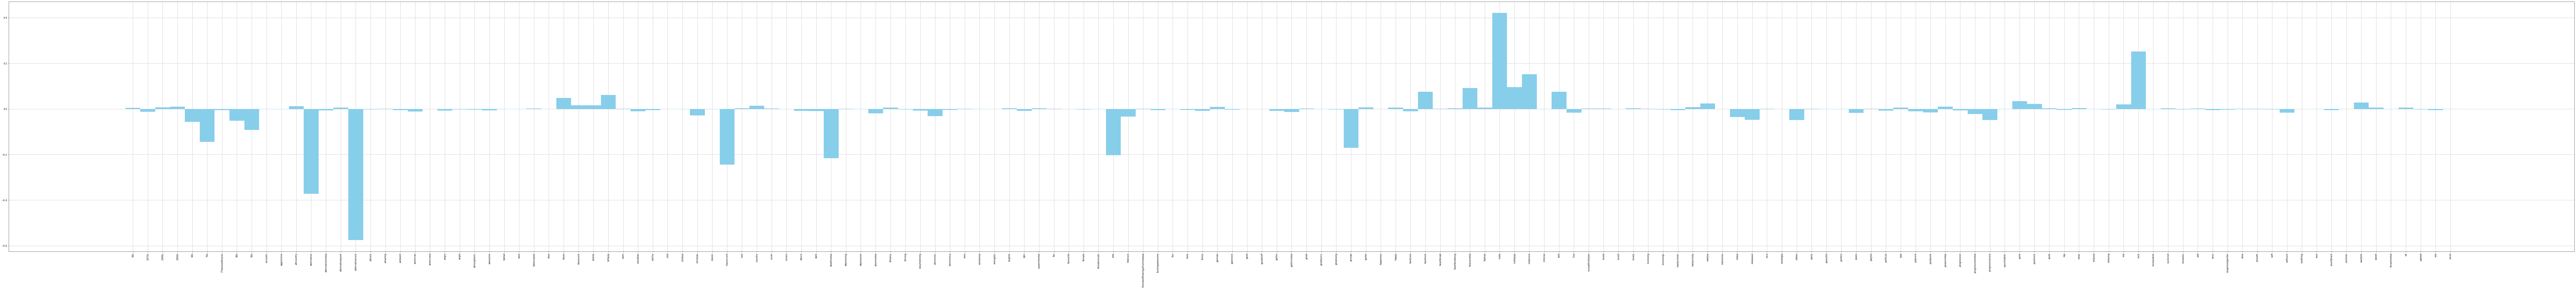

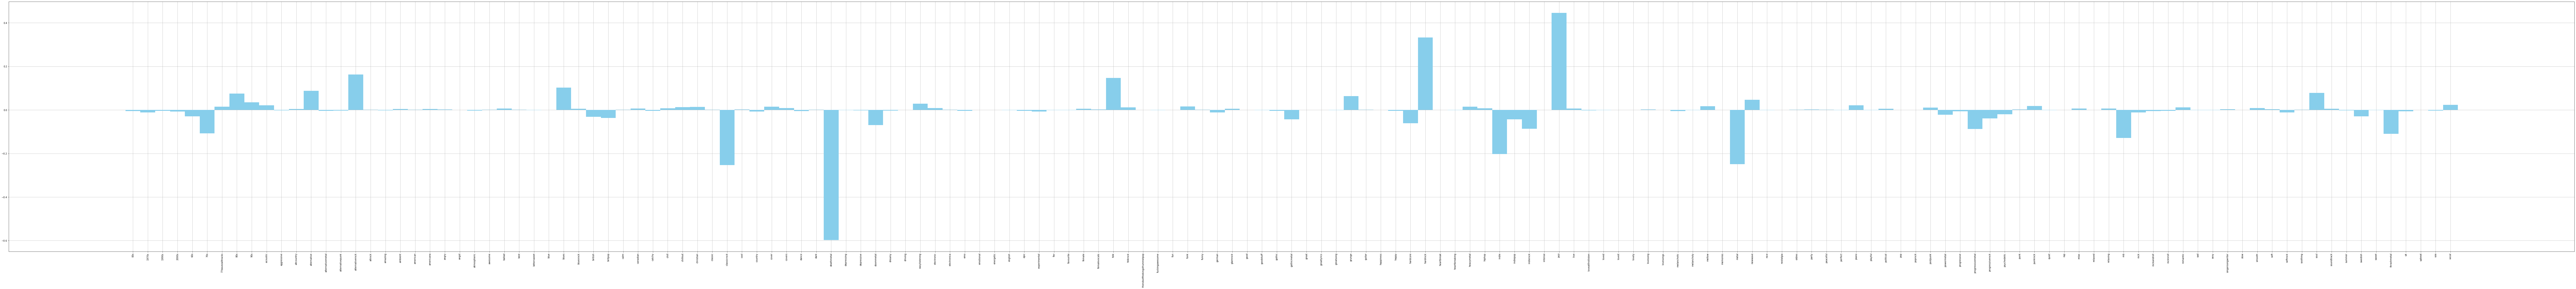

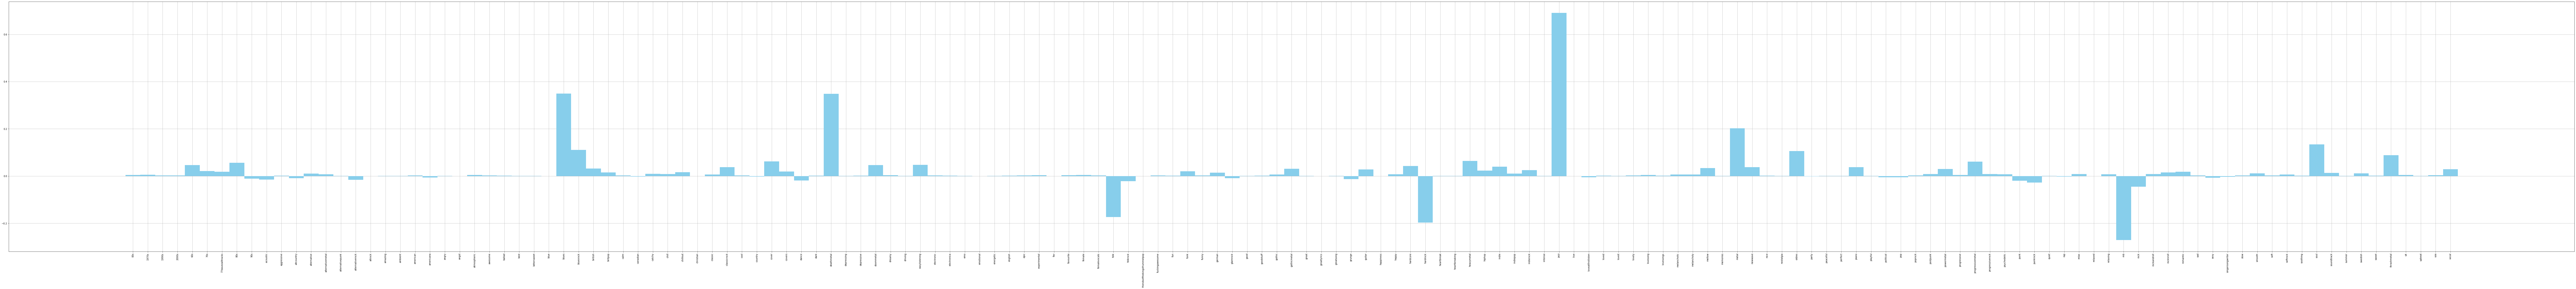

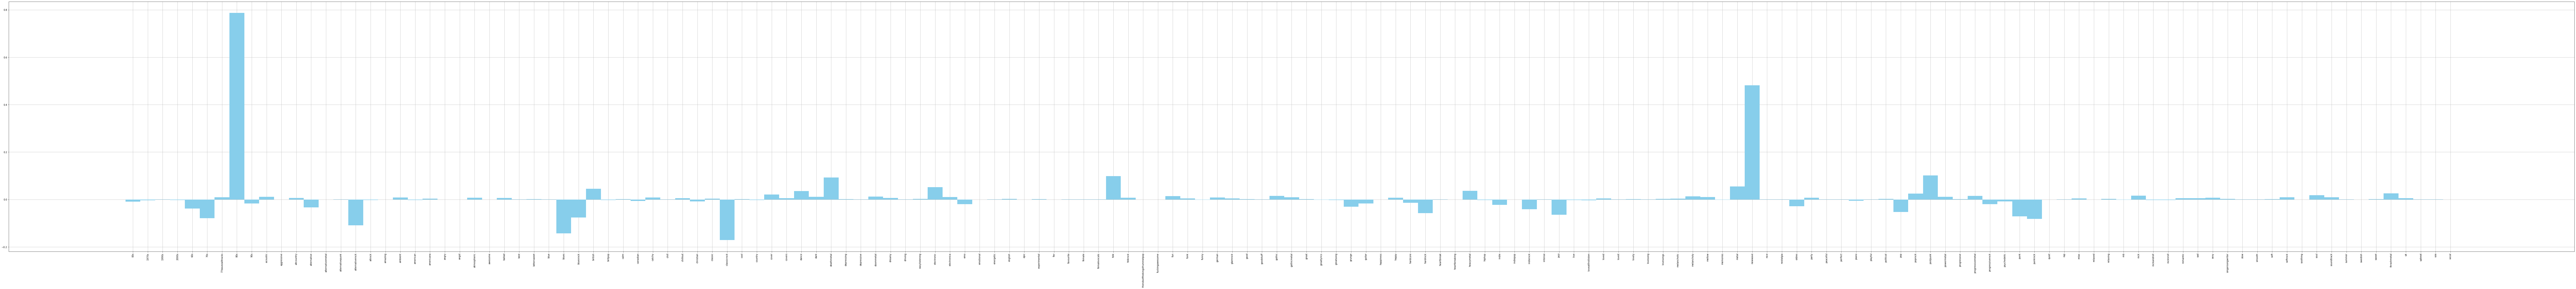

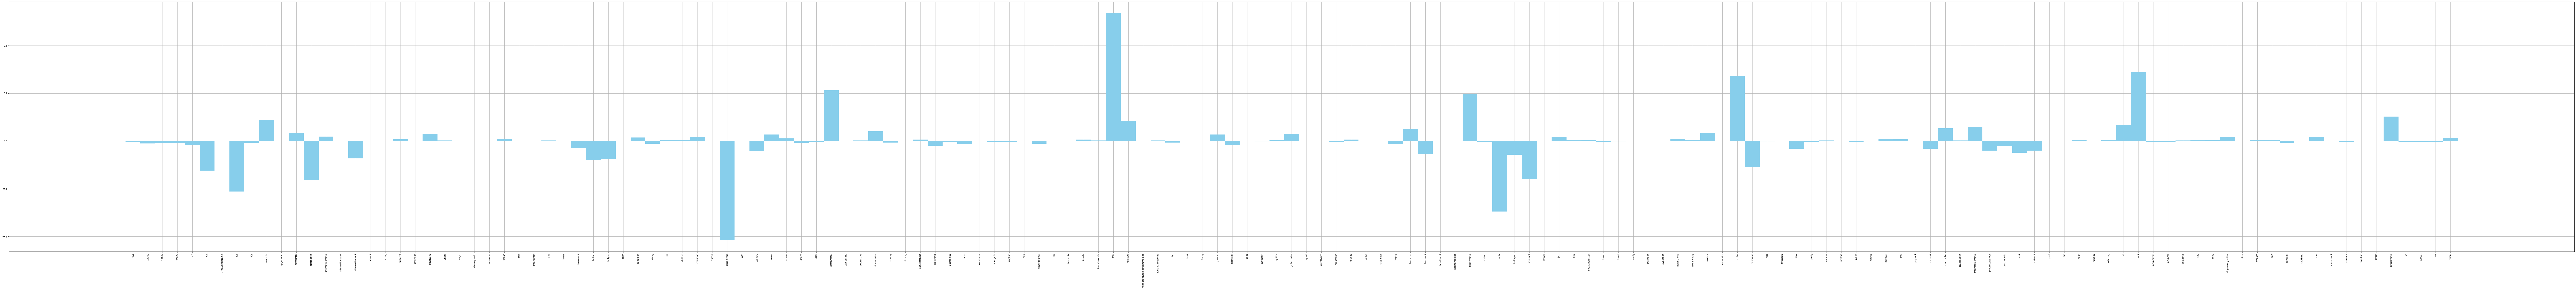

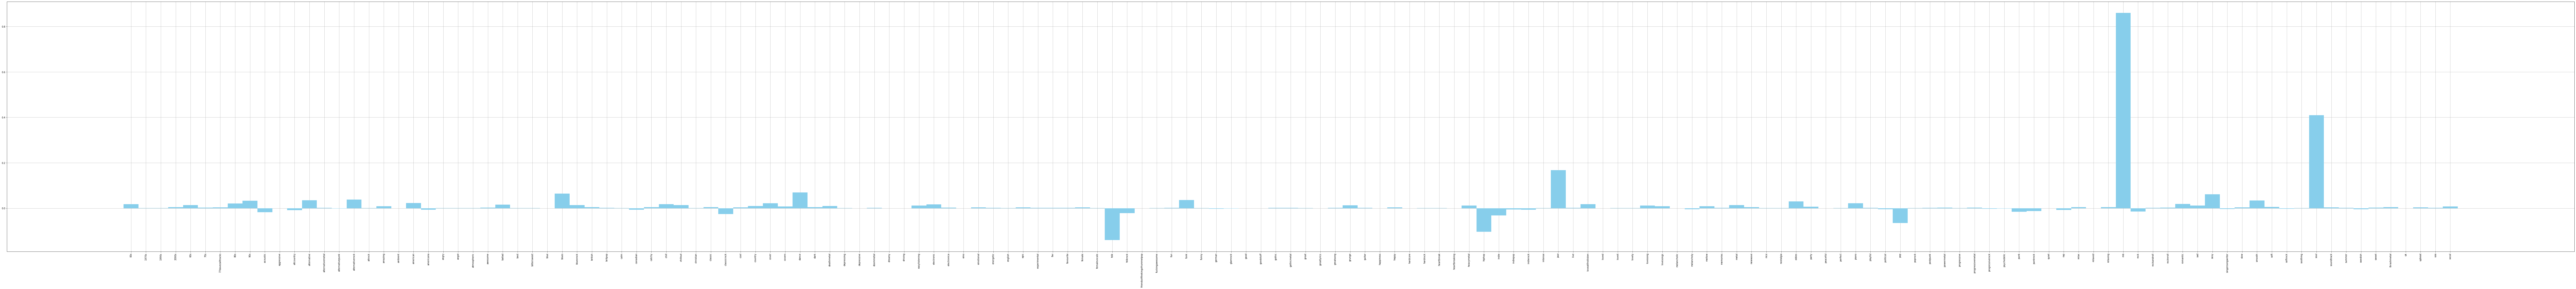

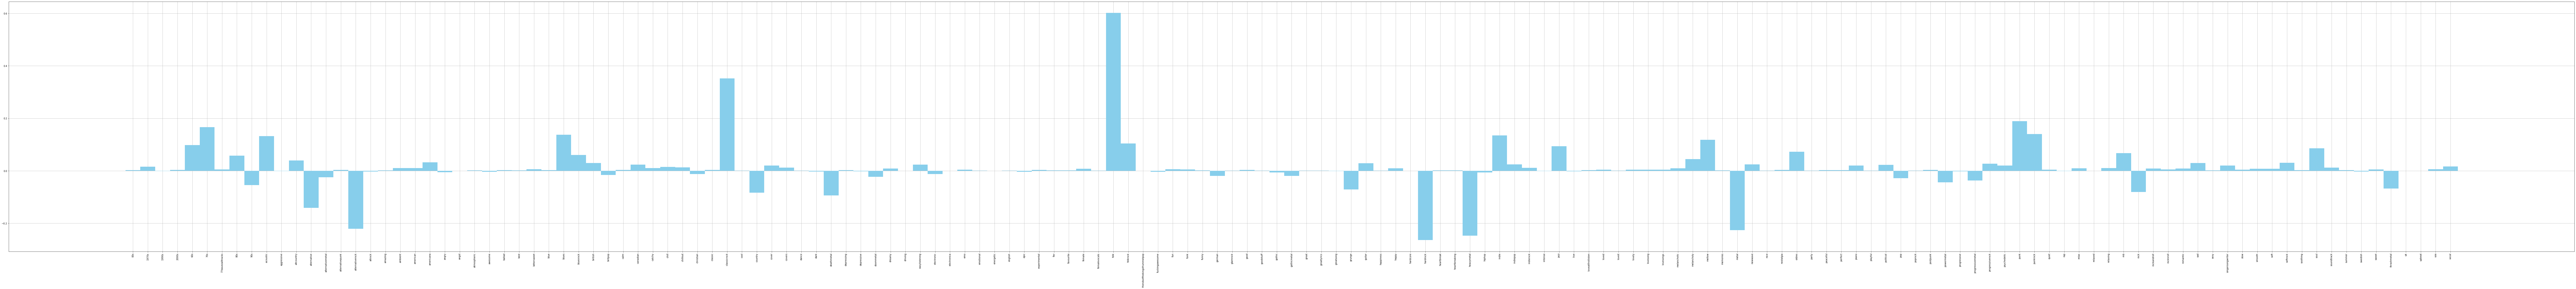

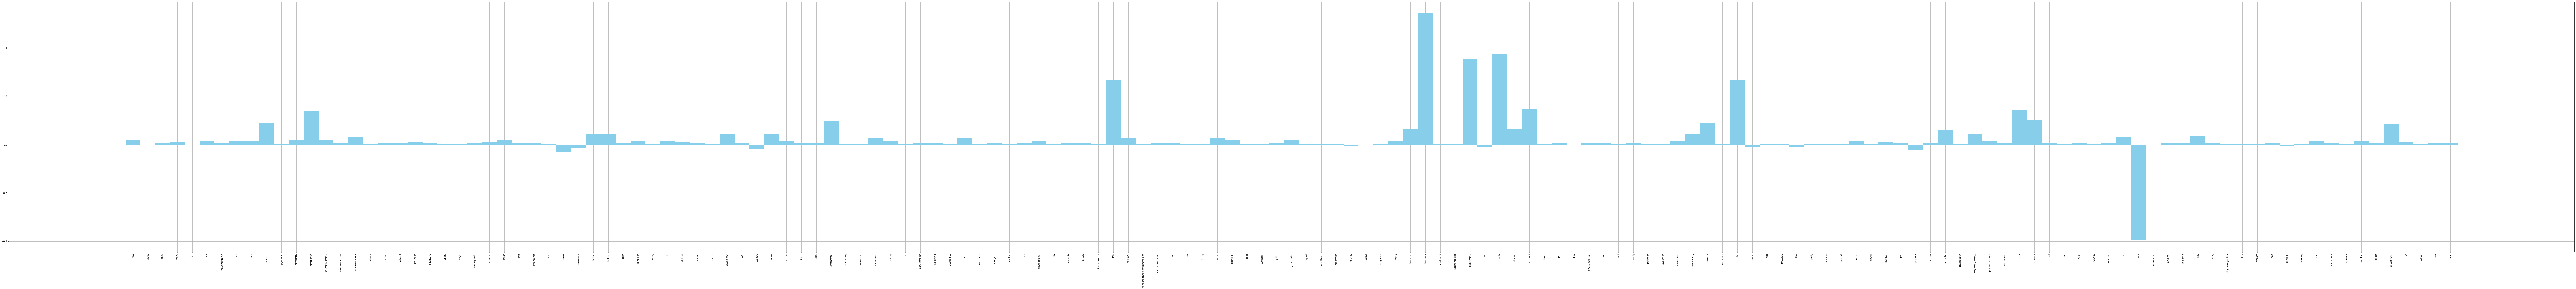

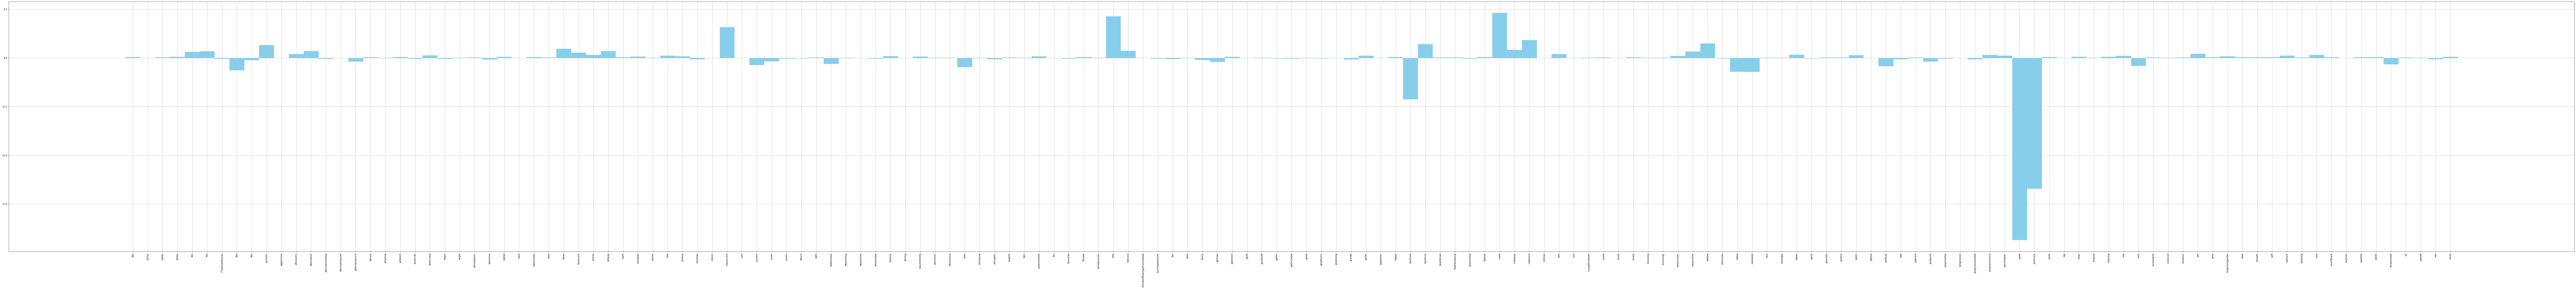

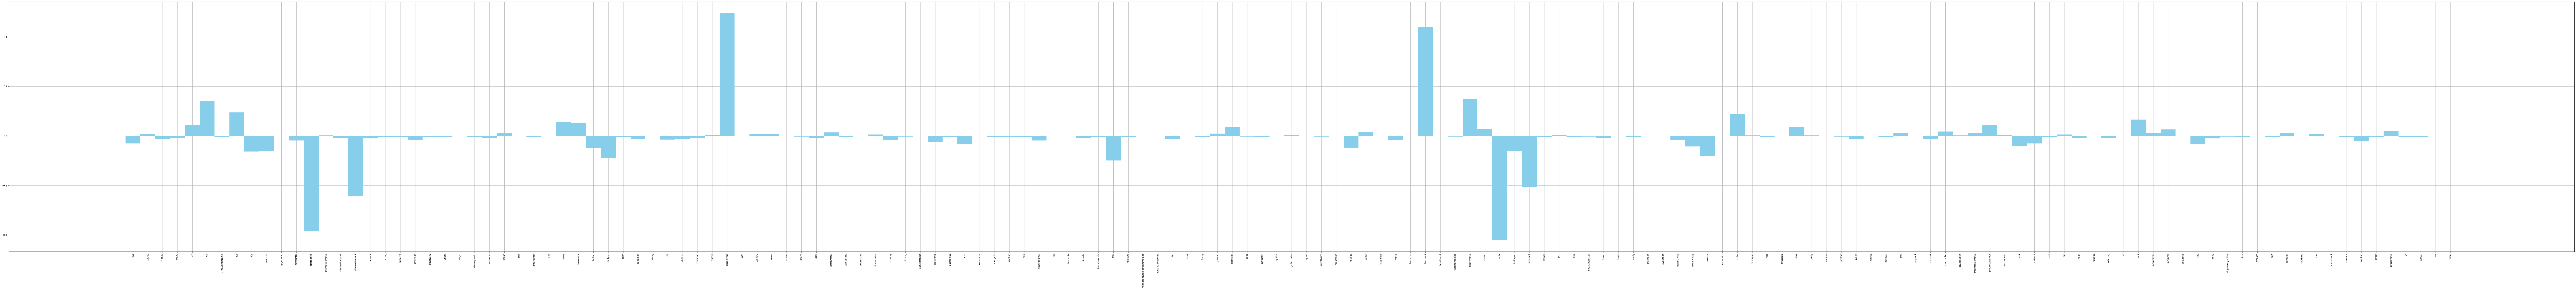

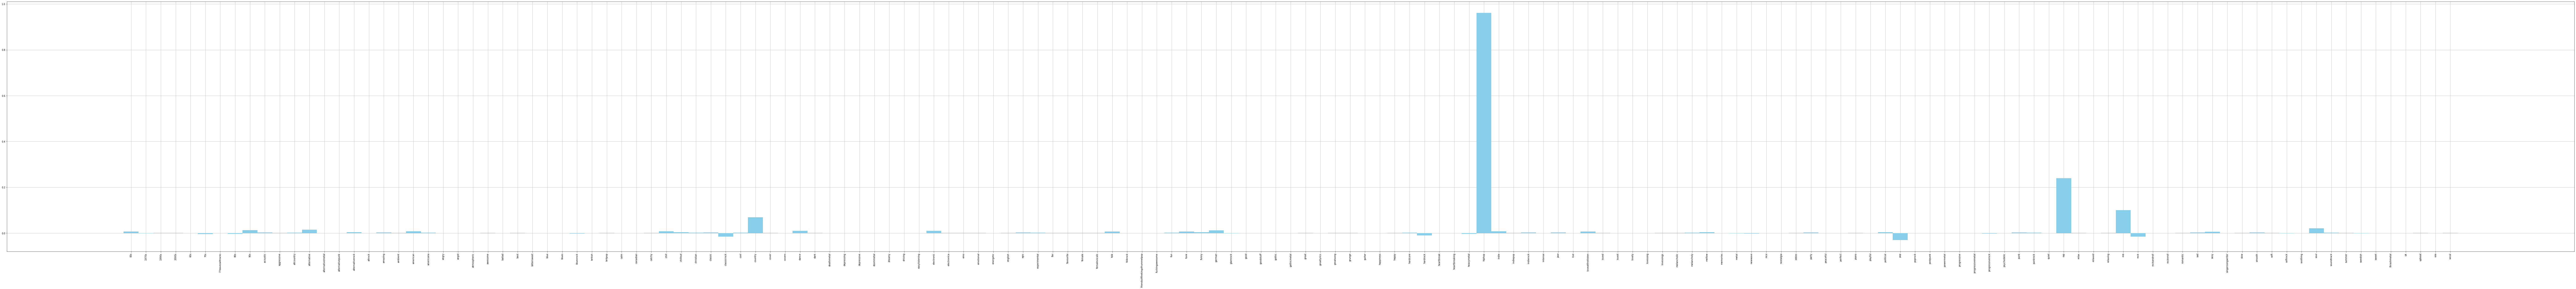

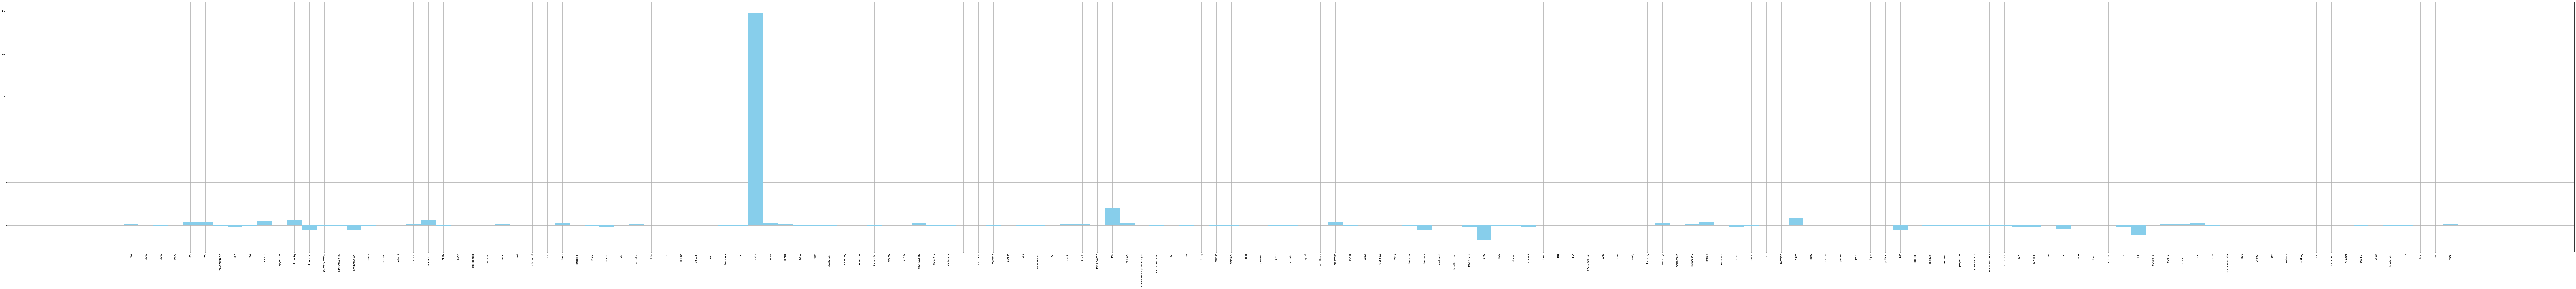

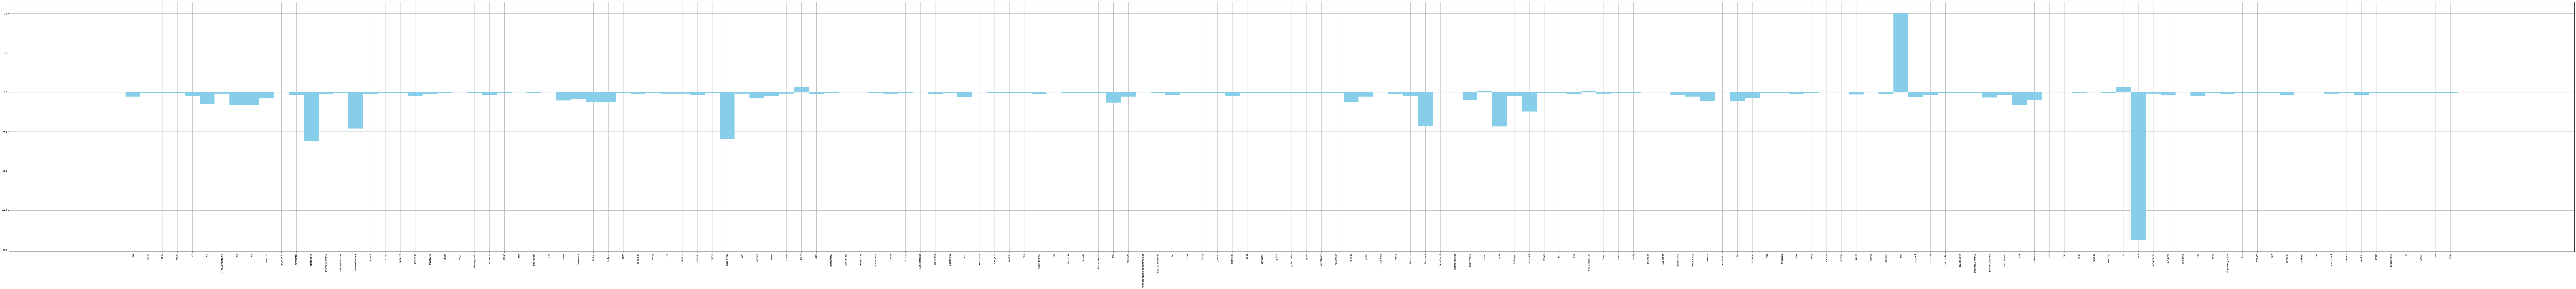

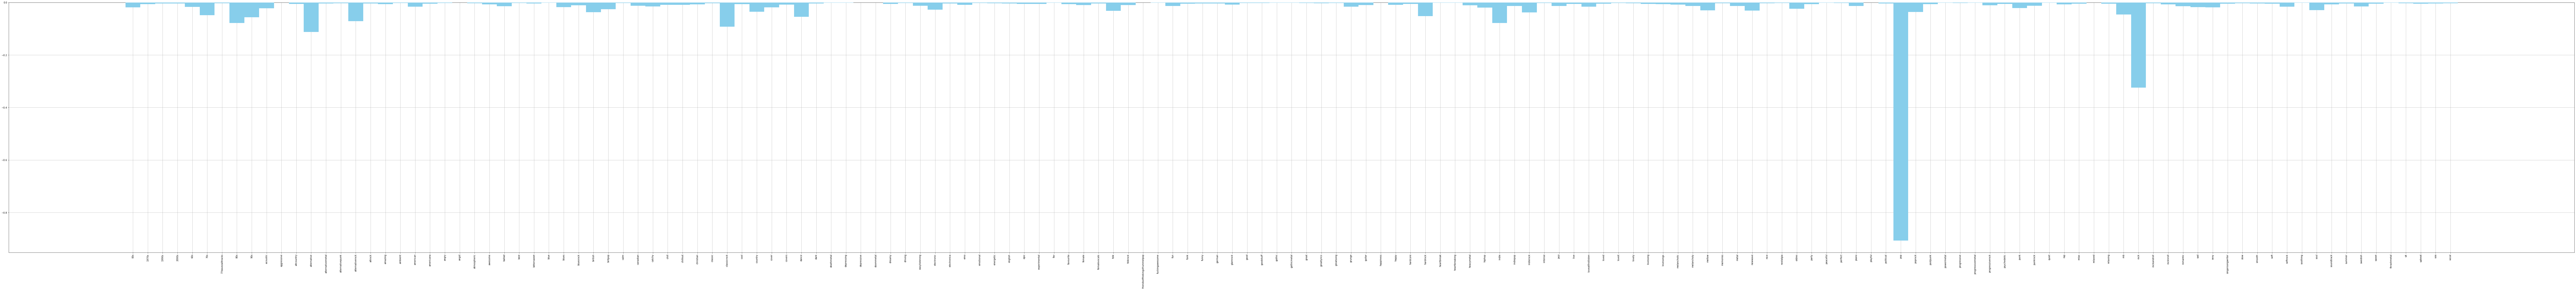

In [43]:
# # generate plots to analyze svd tags

new_tags_by_old_tags = (v.T).tolist()

for new_tag_num in range(v.shape[1]):

    tag_range = range(len(new_tags_by_old_tags[new_tag_num]))

    fig = plt.figure(figsize=(200, 20))

    ax = fig.add_subplot(111)

    ax.bar(tag_range, new_tags_by_old_tags[new_tag_num], width =1)

    ticks = [(1 * i) for i in tag_range]

    ax.set_xticks(ticks)
    ax.set_xticklabels(feature_names, rotation=90)

    ax.grid(zorder=0)
    ax.bar(tag_range, new_tags_by_old_tags[new_tag_num], width=1, align='center', color='skyblue', zorder=3)

    # plt.show()
    fig.savefig(fname = "./newtag" + str(new_tag_num) + "_relations.png")


In [33]:
cols_to_invert = {0, 1, 14}

In [34]:
named_tags = {
    "Blues": 0,
    "Alternative": 1,
    "Metal": 2,
    "Jazz": 3,
    "Rnb": 6,
    "Rock": 8,
    "Punk": 9,
    "Hip-Hop": 10,
    "Country": 12,
    "Pop": 14
}

In [35]:
r = 0.5
USr = u @ (np.diag(s) ** r)
USr.shape

(32028, 15)

In [36]:
USr = USr.T
for dim in cols_to_invert:
    USr[dim] *= -1
USr = USr.T

In [37]:
with open('tag_svd_embeddings.json', 'w') as fp:
  json.dump(USr.tolist(), fp)

In [38]:
with open('data/albums_to_song_indexes.json', 'r') as fp:
  albums_to_song_indexes = json.load(fp)

In [39]:
albums_to_tag_embeddings = dict()

In [40]:
for album, song_indexes in albums_to_song_indexes.items():
    album_tag_embedding = np.zeros(15)
    for s_idx in song_indexes:
        album_tag_embedding += USr[s_idx]
    
    album_tag_embedding /= len(song_indexes)

    albums_to_tag_embeddings[album] = album_tag_embedding.tolist()

In [41]:
with open('albums_to_tag_svd_embeddings.json', 'w') as fp:
  json.dump(albums_to_tag_embeddings, fp)

In [42]:
with open('named_tags.json', 'w') as fp:
  json.dump(named_tags, fp)

In [24]:
# print(len(dataset_dict_list))

In [25]:
# print(dataset_dict_list[0])

In [26]:
# training_json = dict()

# for tag_scores, song_dict, weighted_tag_string in zip(u, dataset_dict_list, weighted_list_of_str_tags):
#         weighted_tag_list = weighted_tag_string.split()
#         # if len(weighted_tag_list) > 9:
#         training_song_data = dict()
#         training_song_data["lyrics"] = song_dict['lyrics']
#         training_song_data["tag_list"] = tag_scores.tolist()
#         song_info = (str(song_dict["artist"]) + '' + str(song_dict["title"]))
#         training_json[song_info] = training_song_data

In [27]:
# print(len(training_json))

In [28]:
# with open('../nlp/songs_training_data.json', 'w') as fp:
#     json.dump(training_json, fp)